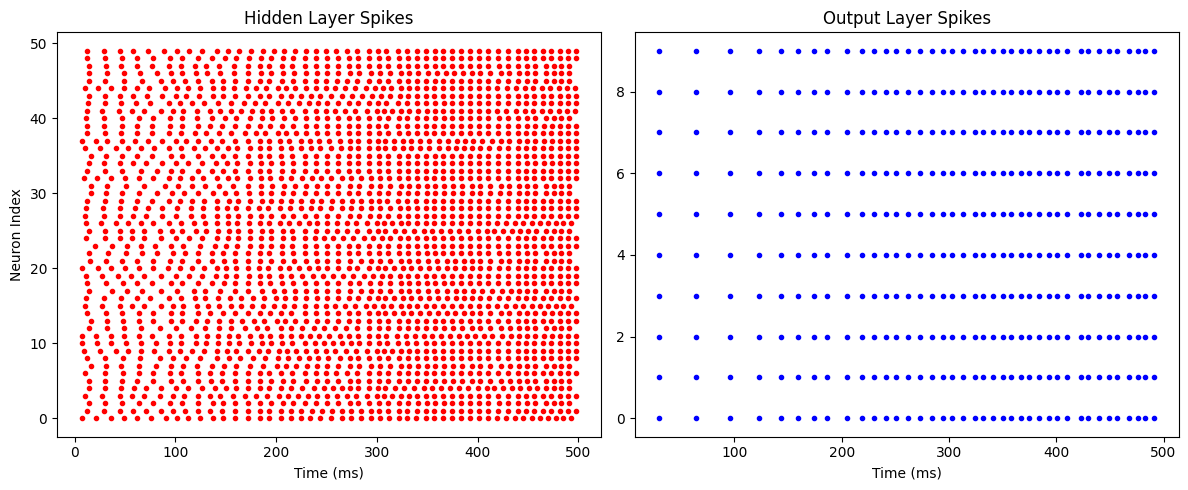

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Network parameters
# -------------------------------
N_input = 100
N_hidden = 50
N_output = 10
sim_time = 500  # ms
dt = 1
time_steps = int(sim_time / dt)

# -------------------------------
# Neuron parameters
# -------------------------------
v_rest = -65.0
v_thresh = -58.0  # Lowered threshold
tau = 10.0
refractory_period = 5

# -------------------------------
# Input generation: high rate
# -------------------------------
input_rate = 100 / 1000  # 100 Hz
input_spikes = np.random.rand(N_input, time_steps) < input_rate

# -------------------------------
# Initial voltage & refractory
# -------------------------------
v_hidden = np.full(N_hidden, v_rest)
v_output = np.full(N_output, v_rest)
ref_hidden = np.zeros(N_hidden)
ref_output = np.zeros(N_output)

# -------------------------------
# Synaptic weights (stronger)
# -------------------------------
w_in_hidden = np.random.rand(N_input, N_hidden) * 2.0
w_hidden_out = np.random.rand(N_hidden, N_output) * 4.0 + 2.0

# -------------------------------
# R-STDP learning
# -------------------------------
eta = 0.01
tau_pre = 20
tau_post = 20
reward = 1.0
pre_in_hidden = np.zeros((N_input, N_hidden))
post_in_hidden = np.zeros((N_input, N_hidden))
pre_hidden_out = np.zeros((N_hidden, N_output))
post_hidden_out = np.zeros((N_hidden, N_output))

# -------------------------------
# Logging
# -------------------------------
hidden_spikes = []
output_spikes = []

# -------------------------------
# Neuron update
# -------------------------------
def lif(v, I, ref):
    ref_active = ref > 0
    v[ref_active] = v_rest
    v[~ref_active] += ((-v[~ref_active] + v_rest + I[~ref_active]) / tau)
    spiked = v >= v_thresh
    ref[spiked] = refractory_period
    v[spiked] = v_rest
    ref -= 1
    return v, spiked, ref

# -------------------------------
# Simulation
# -------------------------------
for t in range(time_steps):
    # Input → Hidden
    spikes_input = input_spikes[:, t]
    I_hidden = np.dot(spikes_input.astype(float), w_in_hidden)
    v_hidden, s_hidden, ref_hidden = lif(v_hidden, I_hidden, ref_hidden)
    hidden_spikes.append(s_hidden.copy())

    # Hidden → Output
    I_output = np.dot(s_hidden.astype(float), w_hidden_out)
    v_output, s_output, ref_output = lif(v_output, I_output, ref_output)
    output_spikes.append(s_output.copy())

    # R-STDP: Input → Hidden
    pre_in_hidden *= np.exp(-1 / tau_pre)
    post_in_hidden *= np.exp(-1 / tau_post)
    for i in range(N_input):
        for j in range(N_hidden):
            if spikes_input[i]:
                pre_in_hidden[i, j] += 1
                w_in_hidden[i, j] += eta * reward * post_in_hidden[i, j]
            if s_hidden[j]:
                post_in_hidden[i, j] += 1
                w_in_hidden[i, j] += eta * reward * pre_in_hidden[i, j]
            w_in_hidden[i, j] = np.clip(w_in_hidden[i, j], 0, 2.0)

    # R-STDP: Hidden → Output
    pre_hidden_out *= np.exp(-1 / tau_pre)
    post_hidden_out *= np.exp(-1 / tau_post)
    for i in range(N_hidden):
        for j in range(N_output):
            if s_hidden[i]:
                pre_hidden_out[i, j] += 1
                w_hidden_out[i, j] += eta * reward * post_hidden_out[i, j]
            if s_output[j]:
                post_hidden_out[i, j] += 1
                w_hidden_out[i, j] += eta * reward * pre_hidden_out[i, j]
            w_hidden_out[i, j] = np.clip(w_hidden_out[i, j], 0, 2.0)

# -------------------------------
# Visualization
# -------------------------------
hidden_spikes = np.array(hidden_spikes).T
output_spikes = np.array(output_spikes).T

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Hidden Layer Spikes')
for i in range(N_hidden):
    times = np.where(hidden_spikes[i])[0]
    plt.plot(times, [i]*len(times), '.r')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')

plt.subplot(1, 2, 2)
plt.title('Output Layer Spikes')
for i in range(N_output):
    times = np.where(output_spikes[i])[0]
    plt.plot(times, [i]*len(times), '.b')
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()



In [ ]:
import numpy as np

def generate_spike_pattern(label, time_steps=300, shape=(34, 34), noise_level=0.01):
    np.random.seed(label)  # deterministic patterns per class
    base_pattern = np.random.rand(*shape) < 0.05  # sparse base

    spike_tensor = np.zeros((time_steps, *shape))
    for t in range(time_steps):
        if t % 10 == 0:  # periodic spiking for structure
            spike_tensor[t][base_pattern] = 1

        # add noise
        noise = np.random.rand(*shape) < noise_level
        spike_tensor[t][noise] = 1

    return spike_tensor.reshape(time_steps, -1)  # (T, 1156)


In [ ]:
import numpy as np

class SNN:
    def __init__(self, input_size=1156, hidden_size=100, output_size=3):
        self.W1 = np.random.rand(input_size, hidden_size) * 0.5
        self.W2 = np.random.rand(hidden_size, output_size) * 0.5
        self.hidden_size = hidden_size
        self.output_size = output_size

    def lif_layer(self, input_spikes, V, spikes, tau=20.0, v_th=1.0):
        V = V * np.exp(-1 / tau) + input_spikes
        spiked = V >= v_th
        V[spiked] = 0
        spikes[spiked] = 1
        return V, spikes

    def forward(self, inputs):  # (T, 1156)
        T = inputs.shape[0]
        hidden_spikes = np.zeros((T, self.hidden_size))
        output_spikes = np.zeros((T, self.output_size))
        V1 = np.zeros(self.hidden_size)
        V2 = np.zeros(self.output_size)

        for t in range(T):
            input_t = inputs[t]
            hidden_input = input_t @ self.W1
            V1, s1 = self.lif_layer(hidden_input, V1, np.zeros_like(V1))
            hidden_spikes[t] = s1

            output_input = s1 @ self.W2
            V2, s2 = self.lif_layer(output_input, V2, np.zeros_like(V2))
            output_spikes[t] = s2

        return hidden_spikes, output_spikes


In [ ]:
def reward_modulated_stdp(W, pre_spikes, post_spikes, reward, lr=0.01):
    for t in range(len(pre_spikes)):
        dw = np.outer(pre_spikes[t], post_spikes[t])
        W += lr * reward * dw
    return W


In [ ]:
import matplotlib.pyplot as plt

labels = [0, 1, 2]
model = SNN()

for episode in range(5):
    support = [(generate_spike_pattern(lbl), lbl) for lbl in labels for _ in range(5)]
    query = [(generate_spike_pattern(lbl), lbl) for lbl in labels]

    dw_total = np.zeros_like(model.W2)
    for spikes, lbl in support:
        h, o = model.forward(spikes)
        pred = np.argmax(o.sum(axis=0))
        reward = 1.0 if pred == lbl else -0.2
        dw_total += reward * np.einsum("ti,tj->ij", h, o)
    model.W2 += 0.01 * dw_total

    # 🧪 Evaluate on query set
    correct = 0
    for spikes, lbl in query:
        _, o = model.forward(spikes)
        pred = np.argmax(o.sum(axis=0))
        correct += (pred == lbl)
    print(f"Episode {episode+1}: Accuracy = {correct}/3")



Episode 1: Accuracy = 1/3
Episode 2: Accuracy = 1/3
Episode 3: Accuracy = 1/3
Episode 4: Accuracy = 1/3
Episode 5: Accuracy = 1/3


In [ ]:
import matplotlib.pyplot as plt

def plot_spike_raster(spikes, title):
    times, neurons = np.where(spikes)
    plt.figure(figsize=(10, 3))
    plt.scatter(times, neurons, s=2)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Neuron")
    plt.show()


In [ ]:
!pip install tonic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.24.4


Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 90.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.3 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.


In [ ]:
import tonic
import tonic.transforms as transforms
from tonic import datasets

transform = transforms.ToFrame(sensor_size=(34, 34, 2), time_window=1000)

trainset = datasets.NMNIST(save_to='./data', train=True, transform=transform)
testset = datasets.NMNIST(save_to='./data', train=False, transform=transform)


  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST


  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./data/NMNIST/test.zip to ./data/NMNIST


In [ ]:
import tonic
import tonic.transforms as transforms
from tonic import datasets
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
import random

selected_classes = [0, 1, 2]
sensor_size = (34, 34, 2)
transform = transforms.ToFrame(sensor_size=sensor_size, time_window=250)

full_dataset = datasets.NMNIST(save_to='./data', train=True, transform=transform)

print("Filtering classes... (this may take a moment)")
filtered_indices = []
for i in range(len(full_dataset)):
    _, label = full_dataset[i]
    if label in selected_classes:
        filtered_indices.append(i)

few_class_dataset = Subset(full_dataset, filtered_indices)

label_map = {original: i for i, original in enumerate(selected_classes)}

def build_class_index_map(dataset, selected_classes, label_map):
    class_indices = {c: [] for c in selected_classes}
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_indices[label].append(i)
    return class_indices

class_to_indices = build_class_index_map(few_class_dataset, selected_classes, label_map)

def create_episode(dataset, class_indices, n_way=3, k_shot=5, q_query=10):
    support_set = []
    query_set = []

    for cls in selected_classes:
        indices = class_indices[cls]
        sampled = random.sample(indices, k_shot + q_query)
        support = sampled[:k_shot]
        query = sampled[k_shot:]

        support_set.extend([(dataset[s_idx][0], label_map[cls]) for s_idx in support])
        query_set.extend([(dataset[q_idx][0], label_map[cls]) for q_idx in query])

    return support_set, query_set

support, query = create_episode(few_class_dataset, class_to_indices)

print(f"Support set: {len(support)} samples")
print(f"Query set: {len(query)} samples")

event_tensor, label = support[0]
print(f"Support sample shape: {event_tensor.shape}, label: {label}")

Filtering classes... (this may take a moment)
Support set: 15 samples
Query set: 30 samples
Support sample shape: (1223, 2, 34, 34), label: 0


In [ ]:
def frames_to_spike_train(frames):
    """
    Convert (T, H, W, P) event frames to (N, T) binary spike train.
    - T: time bins
    - H, W: spatial
    - P: polarity channels (ON/OFF)
    - N = H * W * P
    """
    T, H, W, P = frames.shape
    spike_train = frames.reshape(T, H * W * P).T  # → (N, T)
    return spike_train.astype(np.uint8)


In [ ]:
example_frame, label = support[0]
spike_train = frames_to_spike_train(example_frame)

print(f"Spike train shape: {spike_train.shape}  # (input_neurons, time)")
print(f"Label: {label}")


Spike train shape: (2312, 1223)  # (input_neurons, time)
Label: 0


In [ ]:
def prepare_set(spike_data):
    spike_trains = []
    labels = []
    for frames, label in spike_data:
        train = frames_to_spike_train(frames)
        spike_trains.append(train)
        labels.append(label)
    return spike_trains, labels

support_trains, support_labels = prepare_set(support)
query_trains, query_labels = prepare_set(query)


In [ ]:
def init_network(input_size, output_size):
    weights = np.random.rand(output_size, input_size) * 0.5
    for i in range(output_size):
        weights[i, i::output_size] += 0.5
    return weights

In [ ]:
def reward_modulated_stdp(weights, pre_spikes, post_spikes, reward, lr=0.01):
    """
    weights: (output_neurons, input_neurons)
    pre_spikes: (input_neurons, T)
    post_spikes: (output_neurons, T)
    reward: +1 (correct) or -1 (wrong)
    """
    T = pre_spikes.shape[1]
    for t in range(T):
        pre = pre_spikes[:, t]
        post = post_spikes[:, t]
        for o in range(weights.shape[0]):
            if post[o]:
                dw = reward * lr * pre
                weights[o] += dw
                weights[o] = np.clip(weights[o], 0, 1)
    return weights

In [ ]:
def run_snn(spike_train, weights, threshold=5):
    """
    spike_train: (input_neurons, T)
    weights: (output_neurons, input_neurons)
    Returns: output_spike_train: (output_neurons, T)
    """
    T = spike_train.shape[1]
    output_size = weights.shape[0]
    output_spikes = np.zeros((output_size, T), dtype=np.uint8)
    membrane = np.zeros(output_size)

    for t in range(T):
        input_t = spike_train[:, t]
        membrane += weights @ input_t
        fired = membrane >= threshold
        output_spikes[:, t] = fired.astype(np.uint8)
        membrane[fired] = 0

    return output_spikes


In [ ]:
def predict(spike_train, weights):
    out_spikes = run_snn(spike_train, weights)
    spike_counts = out_spikes.sum(axis=1)
    return np.argmax(spike_counts)


In [ ]:
def evaluate(query_trains, query_labels, weights):
    correct = 0
    for spikes, label in zip(query_trains, query_labels):
        pred = predict(spikes, weights)
        correct += (pred == label)
    accuracy = correct / len(query_labels)
    return accuracy


In [ ]:
def train_on_support(support_trains, support_labels, weights, n_epochs=1):
    for epoch in range(n_epochs):
        print(f"Epoch {epoch+1}")
        for i, (spikes, label) in enumerate(zip(support_trains, support_labels)):
            out_spikes = run_snn(spikes, weights)
            predicted = np.argmax(out_spikes.sum(axis=1))
            reward = 1 if predicted == label else -1
            weights = reward_modulated_stdp(weights, spikes, out_spikes, reward, lr=0.1)

            print(f" Sample {i}: Label={label}, Pred={predicted}, Reward={reward}")
            print(" Output spikes:", out_spikes.sum(axis=1))
    return weights


In [ ]:
input_neurons = support_trains[0].shape[0]
output_neurons = len(set(support_labels))

weights = init_network(input_neurons, output_neurons)

weights = train_on_support(support_trains, support_labels, weights, n_epochs=3)

acc = evaluate(query_trains, query_labels, weights)
print(f"Query set accuracy: {acc*100:.2f}%")

Epoch 1
 Sample 0: Label=0, Pred=0, Reward=1
 Output spikes: [353 351 342]
 Sample 1: Label=0, Pred=0, Reward=1
 Output spikes: [454 445 443]
 Sample 2: Label=0, Pred=1, Reward=-1
 Output spikes: [646 650 641]
 Sample 3: Label=0, Pred=1, Reward=-1
 Output spikes: [238 243 239]
 Sample 4: Label=0, Pred=0, Reward=1
 Output spikes: [106 104 101]
 Sample 5: Label=1, Pred=0, Reward=-1
 Output spikes: [67 65 62]
 Sample 6: Label=1, Pred=0, Reward=-1
 Output spikes: [103  99  95]
 Sample 7: Label=1, Pred=0, Reward=-1
 Output spikes: [87 84 80]
 Sample 8: Label=1, Pred=0, Reward=-1
 Output spikes: [64 64 61]
 Sample 9: Label=1, Pred=0, Reward=-1
 Output spikes: [58 58 53]
 Sample 10: Label=2, Pred=1, Reward=-1
 Output spikes: [90 91 89]
 Sample 11: Label=2, Pred=1, Reward=-1
 Output spikes: [127 129 128]
 Sample 12: Label=2, Pred=1, Reward=-1
 Output spikes: [71 72 68]
 Sample 13: Label=2, Pred=0, Reward=-1
 Output spikes: [23 22 23]
 Sample 14: Label=2, Pred=0, Reward=-1
 Output spikes: [45 4

In [ ]:
accuracies = []

for _ in range(10):  # 10 few-shot episodes
    class_to_indices = build_class_index_map(few_class_dataset, selected_classes, label_map)
    support, query = create_episode(few_class_dataset, class_to_indices, n_way=3, k_shot=5, q_query=5)

    support_trains, support_labels = prepare_set(support)
    query_trains, query_labels = prepare_set(query)

    input_neurons = support_trains[0].shape[0]
    output_neurons = len(set(support_labels))

    weights = init_network(input_neurons, output_neurons)
    weights = train_on_support(support_trains, support_labels, weights)
    acc = evaluate(query_trains, query_labels, weights)
    accuracies.append(acc)

print(f"Average accuracy over 10 episodes: {np.mean(accuracies)*100:.2f}%")
avg_input_spikes = np.mean([train.sum() for train in support_trains])
print(f"Average spikes per sample: {avg_input_spikes}")

Epoch 1
 Sample 0: Label=0, Pred=2, Reward=-1
 Output spikes: [385 387 388]
 Sample 1: Label=0, Pred=0, Reward=1
 Output spikes: [107 105  97]
 Sample 2: Label=0, Pred=0, Reward=1
 Output spikes: [148 139 129]
 Sample 3: Label=0, Pred=0, Reward=1
 Output spikes: [160 148 141]
 Sample 4: Label=0, Pred=0, Reward=1
 Output spikes: [342 317 311]
 Sample 5: Label=1, Pred=0, Reward=-1
 Output spikes: [275 266 255]
 Sample 6: Label=1, Pred=0, Reward=-1
 Output spikes: [229 229 208]
 Sample 7: Label=1, Pred=0, Reward=-1
 Output spikes: [120 116 109]
 Sample 8: Label=1, Pred=0, Reward=-1
 Output spikes: [140 133 131]
 Sample 9: Label=1, Pred=1, Reward=1
 Output spikes: [59 61 60]
 Sample 10: Label=2, Pred=1, Reward=-1
 Output spikes: [268 273 262]
 Sample 11: Label=2, Pred=0, Reward=-1
 Output spikes: [125 125 117]
 Sample 12: Label=2, Pred=0, Reward=-1
 Output spikes: [181 168 172]
 Sample 13: Label=2, Pred=1, Reward=-1
 Output spikes: [43 44 43]
 Sample 14: Label=2, Pred=0, Reward=-1
 Output 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# -----------------------
# Network Initialization
# -----------------------
def init_network(input_size, output_size):
    weights = np.random.rand(output_size, input_size) * 0.5
    return weights

# -----------------------
# WTA SNN Inference
# -----------------------
def run_snn_wta(spike_train, weights, threshold=5):
    T = spike_train.shape[1]
    output_size = weights.shape[0]
    output_spikes = np.zeros((output_size, T), dtype=np.uint8)
    membrane = np.zeros(output_size)

    for t in range(T):
        input_t = spike_train[:, t]
        membrane += weights @ input_t
        if np.any(membrane >= threshold):
            winner = np.argmax(membrane)
            output_spikes[winner, t] = 1
            membrane[winner] = 0
    return output_spikes

# -----------------------
# Reward-Modulated STDP
# -----------------------
def reward_modulated_stdp(weights, pre_spikes, post_spikes, reward, lr=0.1):
    T = pre_spikes.shape[1]
    for t in range(T):
        pre = pre_spikes[:, t]
        post = post_spikes[:, t]
        for o in range(weights.shape[0]):
            if post[o]:
                dw = reward * lr * pre
                weights[o] += dw
                weights[o] = np.clip(weights[o], 0, 1)
    return weights

# -----------------------
# Training Loop
# -----------------------
def train_on_support(support_trains, support_labels, weights, n_epochs=3):
    for epoch in range(n_epochs):
        print(f"\nEpoch {epoch+1}")
        for i, (spikes, label) in enumerate(zip(support_trains, support_labels)):
            out_spikes = run_snn_wta(spikes, weights)
            predicted = np.argmax(out_spikes.sum(axis=1))
            reward = 1 if predicted == label else -1
            weights = reward_modulated_stdp(weights, spikes, out_spikes, reward)

            print(f" Sample {i}: Label={label}, Pred={predicted}, Reward={reward}")
            print("  Output spikes:", out_spikes.sum(axis=1))
    return weights

# -----------------------
# Inference
# -----------------------
def predict(spike_train, weights):
    out_spikes = run_snn_wta(spike_train, weights)
    spike_counts = out_spikes.sum(axis=1)
    return np.argmax(spike_counts)

# -----------------------
# Evaluation
# -----------------------
def evaluate(query_trains, query_labels, weights):
    correct = 0
    for spikes, label in zip(query_trains, query_labels):
        pred = predict(spikes, weights)
        correct += (pred == label)
    accuracy = correct / len(query_labels)
    return accuracy

# -----------------------
# Visualization (Optional)
# -----------------------
def plot_raster(spike_train, title="Output spikes"):
    neuron_ids, times = np.nonzero(spike_train)
    plt.figure(figsize=(8, 4))
    plt.scatter(times, neuron_ids, s=5)
    plt.xlabel("Time")
    plt.ylabel("Neuron")
    plt.title(title)
    plt.show()


In [ ]:
accuracies = []

for _ in range(10):
    class_to_indices = build_class_index_map(few_class_dataset, selected_classes, label_map)
    support, query = create_episode(few_class_dataset, class_to_indices, n_way=3, k_shot=10, q_query=5)

    support_trains, support_labels = prepare_set(support)
    query_trains, query_labels = prepare_set(query)

    input_neurons = support_trains[0].shape[0]
    output_neurons = len(set(support_labels))

    weights = init_network(input_neurons, output_neurons)
    weights = train_on_support(support_trains, support_labels, weights, n_epochs=3)

    acc = evaluate(query_trains, query_labels, weights)
    print(f"Episode accuracy: {acc*100:.2f}%")
    accuracies.append(acc)

print(f"\n✅ Average accuracy over 10 episodes: {np.mean(accuracies)*100:.2f}%")


Epoch 1
 Sample 0: Label=0, Pred=1, Reward=-1
  Output spikes: [132 140 137]
 Sample 1: Label=0, Pred=1, Reward=-1
  Output spikes: [178 180 171]
 Sample 2: Label=0, Pred=1, Reward=-1
  Output spikes: [ 97 109  99]
 Sample 3: Label=0, Pred=2, Reward=-1
  Output spikes: [83 80 84]
 Sample 4: Label=0, Pred=0, Reward=1
  Output spikes: [35 34 35]
 Sample 5: Label=0, Pred=2, Reward=-1
  Output spikes: [72 70 73]
 Sample 6: Label=0, Pred=1, Reward=-1
  Output spikes: [23 24 23]
 Sample 7: Label=0, Pred=2, Reward=-1
  Output spikes: [34 33 37]
 Sample 8: Label=0, Pred=0, Reward=1
  Output spikes: [40 38 39]
 Sample 9: Label=0, Pred=1, Reward=-1
  Output spikes: [58 62 61]
 Sample 10: Label=1, Pred=2, Reward=-1
  Output spikes: [22 22 24]
 Sample 11: Label=1, Pred=0, Reward=-1
  Output spikes: [15 15 15]
 Sample 12: Label=1, Pred=2, Reward=-1
  Output spikes: [19 18 20]
 Sample 13: Label=1, Pred=0, Reward=-1
  Output spikes: [22 21 22]
 Sample 14: Label=1, Pred=2, Reward=-1
  Output spikes: 

In [ ]:
import numpy as np
from collections import defaultdict

# --- Configuration for the simulation ---
NUM_CLASSES_PER_TASK = 5  # How many different digit classes in one task (N-way classification)
N_SHOT = 5                # Number of support examples per class (K-shot learning, e.g., 1-shot, 5-shot)
N_QUERY = 15              # Number of query examples per class
FEATURE_DIMENSION = 10    # Dimension of our simulated feature vectors (embeddings)
NUM_TASKS_TO_SIMULATE = 5 # How many meta-learning tasks to run


# --- Simulated MNIST Data Generation ---
# In a real scenario, this would come from a pre-trained feature extractor (e.g., a CNN)
# Here, we simulate features based on class (digit) to make them distinguishable.
def generate_features(digit_class: int) -> np.ndarray:
    """
    Generates a simulated feature vector for a given digit class.
    Features for the same class will be clustered, but with some noise.
    """
    # Create a base feature vector somewhat unique to the digit class
    base_features = np.array([
        (digit_class * 0.5 + np.random.uniform(-0.1, 0.1)) for _ in range(FEATURE_DIMENSION)
    ])

    # Add more noise to simulate variability within a class
    features = base_features + np.random.uniform(-0.5, 0.5, size=FEATURE_DIMENSION) * 0.5
    return features


# --- Task Generation Logic ---
def generate_meta_learning_task():
    """
    Generates a single meta-learning task (episode) for few-shot classification.
    A task consists of a support set and a query set for randomly selected classes.
    """
    # Randomly select NUM_CLASSES_PER_TASK unique digits for this task
    available_digits = list(range(10))  # Digits 0-9
    np.random.shuffle(available_digits)
    selected_digits = sorted(available_digits[:NUM_CLASSES_PER_TASK])

    support_set = []
    query_set = []

    for digit in selected_digits:
        # Generate N_SHOT support examples for this digit
        for _ in range(N_SHOT):
            support_set.append({
                'class': digit,
                'features': generate_features(digit)
            })
        # Generate N_QUERY query examples for this digit
        for _ in range(N_QUERY):
            query_set.append({
                'class': digit,
                'features': generate_features(digit)
            })

    # Shuffle query set to mix classes and avoid sequential bias
    np.random.shuffle(query_set)

    return {
        'selected_digits': selected_digits,
        'support_set': support_set,
        'query_set': query_set,
    }


# --- Core Meta-Learning Logic (Prototypical Networks) ---
def run_prototypical_network(task: dict) -> tuple[list, float]:
    """
    Implements the Prototypical Network algorithm for a given task.
    1. Computes prototypes from the support set.
    2. Classifies query examples based on distance to prototypes.
    """
    support_set = task['support_set']
    query_set = task['query_set']
    class_prototypes = {}  # Stores the prototype (mean embedding) for each class

    # 1. Compute Prototypes from Support Set
    # Group support examples by class
    grouped_support = defaultdict(list)
    for item in support_set:
        grouped_support[item['class']].append(item['features'])

    # Calculate the mean feature vector (prototype) for each class
    for class_name, features_for_class in grouped_support.items():
        prototype = np.mean(features_for_class, axis=0)
        class_prototypes[class_name] = prototype

    # 2. Classify Query Set Examples
    predictions = []
    correct_count = 0

    for query_item in query_set:
        min_distance = float('inf')
        predicted_class = None

        # Iterate through each prototype
        for class_name, prototype in class_prototypes.items():
            # Calculate Euclidean distance between query item's features and prototype
            distance = np.linalg.norm(query_item['features'] - prototype)

            if distance < min_distance:
                min_distance = distance
                predicted_class = class_name

        predictions.append({
            'true_class': query_item['class'],
            'predicted_class': predicted_class,
            'is_correct': (predicted_class == query_item['class'])
        })

        if predicted_class == query_item['class']:
            correct_count += 1

    accuracy = (correct_count / len(query_set)) * 100 if len(query_set) > 0 else 0
    return predictions, accuracy


# --- Main simulation loop ---
if __name__ == "__main__":
    print("Starting Meta-Learning (Prototypical Networks) Simulation...\n")
    print(f"Configuration: {NUM_CLASSES_PER_TASK}-way, {N_SHOT}-shot classification.")
    print(f"Feature Dimension: {FEATURE_DIMENSION}\n")

    all_accuracies = []

    for i in range(1, NUM_TASKS_TO_SIMULATE + 1):
        print(f"--- Running Task {i}/{NUM_TASKS_TO_SIMULATE} ---")
        task = generate_meta_learning_task()

        print(f"  Selected Digits for this Task: {task['selected_digits']}")
        print(f"  Support Set Size: {len(task['support_set'])} examples ({N_SHOT} per class)")
        print(f"  Query Set Size: {len(task['query_set'])} examples ({N_QUERY} per class)")

        predictions, accuracy = run_prototypical_network(task)
        all_accuracies.append(accuracy)

        print(f"  Task Accuracy: {accuracy:.2f}%\n")

        # Optionally print a few predictions to see how it performs
        # for j in range(min(5, len(predictions))):
        #     p = predictions[j]
        #     print(f"    Query {j+1}: True Class = {p['true_class']}, Predicted = {p['predicted_class']} ({'Correct' if p['is_correct'] else 'Incorrect'})")
        # if len(predictions) > 5:
        #     print("    ...")
        # print("")

    avg_accuracy = np.mean(all_accuracies) if all_accuracies else 0
    print(f"--- Simulation Complete ---")
    print(f"Average Accuracy across {NUM_TASKS_TO_SIMULATE} Tasks: {avg_accuracy:.2f}%")


Starting Meta-Learning (Prototypical Networks) Simulation...

Configuration: 5-way, 5-shot classification.
Feature Dimension: 10

--- Running Task 1/5 ---
  Selected Digits for this Task: [0, 2, 3, 4, 7]
  Support Set Size: 25 examples (5 per class)
  Query Set Size: 75 examples (15 per class)
  Task Accuracy: 100.00%

--- Running Task 2/5 ---
  Selected Digits for this Task: [0, 1, 5, 6, 7]
  Support Set Size: 25 examples (5 per class)
  Query Set Size: 75 examples (15 per class)
  Task Accuracy: 100.00%

--- Running Task 3/5 ---
  Selected Digits for this Task: [1, 3, 4, 7, 9]
  Support Set Size: 25 examples (5 per class)
  Query Set Size: 75 examples (15 per class)
  Task Accuracy: 100.00%

--- Running Task 4/5 ---
  Selected Digits for this Task: [4, 5, 7, 8, 9]
  Support Set Size: 25 examples (5 per class)
  Query Set Size: 75 examples (15 per class)
  Task Accuracy: 100.00%

--- Running Task 5/5 ---
  Selected Digits for this Task: [3, 6, 7, 8, 9]
  Support Set Size: 25 examples 

In [ ]:
!pip install snntorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import snntorch as snn
from snntorch import surrogate
from snntorch import utils
from snntorch import functional as SF
import numpy as np
import random
import math
from collections import defaultdict

# --- 1. Configuration and Hyperparameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SNN parameters
BETA = 0.95  # decay rate for Leaky Integrate-and-Fire neurons
SPIKE_GRAD_BETA = 5     # Beta for surrogate gradient (controls slope)
NUM_STEPS = 50          # Number of time steps for SNN simulation

# Meta-learning parameters
NUM_CLASSES_PER_TASK = 5  # N-way classification
N_SHOT = 5                # K-shot learning
N_QUERY = 15              # Number of query examples per class
NUM_META_TRAIN_TASKS = 1000 # Number of meta-training episodes
NUM_META_TEST_TASKS = 50    # Number of meta-testing episodes
LEARNING_RATE = 1e-3

# Data parameters
IMG_SIZE = 28
NUM_CHANNELS = 1

# --- 2. Data Loading and Task Generation ---

class MNISTFewShotDataset(Dataset):
    """
    A custom dataset class to facilitate few-shot task generation from MNIST.
    This stores the entire MNIST dataset and allows sampling of tasks.
    """
    def __init__(self, root, train=True, transform=None):
        self.mnist = datasets.MNIST(root=root, train=train, download=True, transform=transform)
        self.labels_to_indices = self._group_data_by_label()

    def _group_data_by_label(self):
        """Groups indices of samples by their class label."""
        labels_to_indices = {i: [] for i in range(10)}
        for i, (_, label) in enumerate(self.mnist):
            labels_to_indices[label].append(i)
        return labels_to_indices

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        pass

    def get_task_batch(self, num_classes_per_task, n_shot, n_query, num_tasks_in_batch):
        """
        Generates a batch of few-shot tasks.
        Each task contains a support set and a query set.
        """
        task_batch = []
        for _ in range(num_tasks_in_batch):
            selected_classes = random.sample(range(10), num_classes_per_task)

            support_images, support_labels = [], []
            query_images, query_labels = [], []

            for class_label in selected_classes:
                available_indices = self.labels_to_indices[class_label]
                random.shuffle(available_indices)

                support_indices = available_indices[:n_shot]
                for idx in support_indices:
                    image, _ = self.mnist[idx]
                    support_images.append(image)
                    support_labels.append(class_label)

                query_indices = available_indices[n_shot : n_shot + n_query]
                for idx in query_indices:
                    image, _ = self.mnist[idx]
                    query_images.append(image)
                    query_labels.append(class_label)

            support_images = torch.stack(support_images).to(device)
            support_labels = torch.tensor(support_labels).long().to(device)
            query_images = torch.stack(query_images).to(device)
            query_labels = torch.tensor(query_labels).long().to(device)

            task_batch.append({
                'selected_classes': selected_classes,
                'support_set': (support_images, support_labels),
                'query_set': (query_images, query_labels)
            })
        return task_batch


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNISTFewShotDataset(root='./data', train=True, transform=transform)
test_dataset = MNISTFewShotDataset(root='./data', train=False, transform=transform)

# --- 3. SNN Feature Extractor Model ---

class SNNFeatureExtractor(nn.Module):
    def __init__(self, beta, spike_grad_beta, num_steps):
        super(SNNFeatureExtractor, self).__init__()

        self.num_steps = num_steps

        self.conv1 = nn.Conv2d(NUM_CHANNELS, 16, kernel_size=5, stride=1, padding=2)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=spike_grad_beta))
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=spike_grad_beta))
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Input size calculation: 28x28 -> (28/2)x(28/2) = 14x14 after pool1
        # 14x14 -> (14/2)x(14/2) = 7x7 after pool2
        # So, 32 channels * 7 * 7 = 1568 features
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=surrogate.fast_sigmoid(slope=spike_grad_beta))


    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        accumulated_features = 0

        for step in range(self.num_steps):
            # Rate coding: input current proportional to pixel intensity
            cur1 = self.conv1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            p1 = self.pool1(spk1)

            cur2 = self.conv2(p1)
            spk2, mem2 = self.lif2(cur2, mem2)
            p2 = self.pool2(spk2)

            p2_flat = p2.view(p2.size(0), -1)

            cur3 = self.fc1(p2_flat)
            spk3, mem3 = self.lif3(cur3, mem3) # Output spiking layer

            accumulated_features += mem3

        return accumulated_features / self.num_steps


# --- 4. Meta-Learning Prototypical Network Logic ---

def euclidean_distance(x1, x2):
    """Calculates Euclidean distance between two tensors."""
    return torch.pow(x1 - x2, 2).sum(dim=1).sqrt()

def prototypical_loss(input_features, target_classes, prototypes):
    """
    Computes the prototypical network loss.
    input_features: features of query set examples
    target_classes: true classes of query set examples
    prototypes: dictionary of {class_idx: prototype_vector}
    """
    unique_classes_in_task = sorted(list(prototypes.keys()))
    class_to_idx_map = {cls: i for i, cls in enumerate(unique_classes_in_task)}
    mapped_target_classes = torch.tensor([class_to_idx_map[cls.item()] for cls in target_classes]).long().to(device)


    distances = []
    for class_label in unique_classes_in_task:
        dist_to_prototype = euclidean_distance(input_features, prototypes[class_label].unsqueeze(0))
        distances.append(dist_to_prototype.unsqueeze(1))

    logits = -torch.cat(distances, dim=1)

    loss = nn.CrossEntropyLoss()(logits, mapped_target_classes)
    return loss, logits


def calculate_accuracy(logits, target_classes, prototypes):
    """
    Calculates the accuracy of predictions.
    """
    unique_classes_in_task = sorted(list(prototypes.keys()))
    class_to_idx_map = {cls: i for i, cls in enumerate(unique_classes_in_task)}
    mapped_target_classes = torch.tensor([class_to_idx_map[cls.item()] for cls in target_classes]).long().to(device)

    predicted_classes = torch.argmax(logits, dim=1)
    correct_predictions = (predicted_classes == mapped_target_classes).sum().item()
    accuracy = correct_predictions / len(target_classes)
    return accuracy


# --- 5. Training and Evaluation Loop ---

def train_meta_model(model, optimizer, train_dataset, num_tasks):
    """Meta-trains the SNN feature extractor."""
    model.train()
    total_loss = 0
    total_accuracy = 0
    print("\n--- Starting Meta-Training ---")
    for i in range(1, num_tasks + 1):
        task_batch = train_dataset.get_task_batch(NUM_CLASSES_PER_TASK, N_SHOT, N_QUERY, num_tasks_in_batch=1)
        task = task_batch[0]

        support_images, support_labels = task['support_set']
        query_images, query_labels = task['query_set']

        optimizer.zero_grad()

        support_features = model(support_images)

        grouped_support_features = defaultdict(list)
        for j, label in enumerate(support_labels):
            grouped_support_features[label.item()].append(support_features[j])

        prototypes = {}
        for class_label, features_list in grouped_support_features.items():
            prototypes[class_label] = torch.stack(features_list).mean(dim=0)

        query_features = model(query_images)

        loss, logits = prototypical_loss(query_features, query_labels, prototypes)

        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(logits, query_labels, prototypes)

        total_loss += loss.item()
        total_accuracy += acc

        if i % 100 == 0:
            avg_loss = total_loss / i
            avg_acc = total_accuracy / i
            print(f"Task {i}/{num_tasks} | Loss: {avg_loss:.4f} | Accuracy: {avg_acc*100:.2f}%")

    avg_loss_final = total_loss / num_tasks
    avg_acc_final = total_accuracy / num_tasks
    print(f"\nMeta-Training Complete. Avg Loss: {avg_loss_final:.4f} | Avg Accuracy: {avg_acc_final*100:.2f}%")
    return avg_loss_final, avg_acc_final


def test_meta_model(model, test_dataset, num_tasks):
    """Evaluates the SNN feature extractor on unseen meta-test tasks."""
    model.eval()
    total_accuracy = 0
    print("\n--- Starting Meta-Testing ---")
    with torch.no_grad():
        for i in range(1, num_tasks + 1):
            task_batch = test_dataset.get_task_batch(NUM_CLASSES_PER_TASK, N_SHOT, N_QUERY, num_tasks_in_batch=1)
            task = task_batch[0]

            support_images, support_labels = task['support_set']
            query_images, query_labels = task['query_set']

            support_features = model(support_images)

            grouped_support_features = defaultdict(list)
            for j, label in enumerate(support_labels):
                grouped_support_features[label.item()].append(support_features[j])

            prototypes = {}
            for class_label, features_list in grouped_support_features.items():
                prototypes[class_label] = torch.stack(features_list).mean(dim=0)

            query_features = model(query_images)

            distances = []
            unique_classes_in_task = sorted(list(prototypes.keys()))
            for class_label in unique_classes_in_task:
                dist_to_prototype = euclidean_distance(query_features, prototypes[class_label].unsqueeze(0))
                distances.append(dist_to_prototype.unsqueeze(1))
            logits = -torch.cat(distances, dim=1)

            acc = calculate_accuracy(logits, query_labels, prototypes)
            total_accuracy += acc

            if i % 10 == 0:
                avg_acc = total_accuracy / i
                print(f"Test Task {i}/{num_tasks} | Accuracy: {avg_acc*100:.2f}%")

    avg_acc_final = total_accuracy / num_tasks
    print(f"\nMeta-Testing Complete. Avg Accuracy: {avg_acc_final*100:.2f}%")
    return avg_acc_final


# --- Main Execution ---
if __name__ == "__main__":
    print(f"Running on device: {device}")

    snn_model = SNNFeatureExtractor(BETA, SPIKE_GRAD_BETA, NUM_STEPS).to(device)
    optimizer = torch.optim.Adam(snn_model.parameters(), lr=LEARNING_RATE)

    train_meta_model(snn_model, optimizer, train_dataset, NUM_META_TRAIN_TASKS)

    test_meta_model(snn_model, test_dataset, NUM_META_TEST_TASKS)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.74MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.28MB/s]


Running on device: cpu

--- Starting Meta-Training ---
Task 100/1000 | Loss: 0.2064 | Accuracy: 93.12%
Task 200/1000 | Loss: 0.1507 | Accuracy: 95.01%
Task 300/1000 | Loss: 0.1238 | Accuracy: 95.93%
Task 400/1000 | Loss: 0.1097 | Accuracy: 96.35%
Task 500/1000 | Loss: 0.0989 | Accuracy: 96.72%
Task 600/1000 | Loss: 0.0911 | Accuracy: 96.96%
Task 700/1000 | Loss: 0.0842 | Accuracy: 97.19%
Task 800/1000 | Loss: 0.0795 | Accuracy: 97.36%
Task 900/1000 | Loss: 0.0757 | Accuracy: 97.48%
Task 1000/1000 | Loss: 0.0720 | Accuracy: 97.61%

Meta-Training Complete. Avg Loss: 0.0720 | Avg Accuracy: 97.61%

--- Starting Meta-Testing ---
Test Task 10/50 | Accuracy: 99.33%
Test Task 20/50 | Accuracy: 99.00%
Test Task 30/50 | Accuracy: 98.93%
Test Task 40/50 | Accuracy: 98.67%
Test Task 50/50 | Accuracy: 98.75%

Meta-Testing Complete. Avg Accuracy: 98.75%
